# GETTING DATA

In [2]:
import json
import requests

import seaborn as sns
from sklearn.metrics import mean_absolute_error
from datetime import date
import numpy as np 
import pandas as pd 
import gc
import datetime
import time
import csv
from matplotlib import pyplot as plt



sns.set_palette('Set2')
%matplotlib inline

Coinmarketcap is famous resoure to know information about almost all cryptocurrencies. Literraly, getting data with this function, later we can check algorithm to any other coin. But my subject is Bitcoin, so let's now stick to it

In [42]:
def cmc_data(market, tag=True):
    market_data = pd.read_html("https://coinmarketcap.com/currencies/" + market + 
                             "/historical-data/?start=20120101&end="+time.strftime("%Y%m%d"), flavor='html5lib')[0]
    if tag:
        market_data.columns = [market_data.columns[0]] + [tag + '_' + i for i in market_data.columns[1:]]
    return market_data

In [84]:
btc_data = cmc_data("bitcoin", tag='BTC')

In [85]:
#btc_data.drop(btc_data.index[[0,1,2,3,4]], inplace=True)

In [86]:
#btc_data.reset_index(drop=True, inplace=True)
#btc_data.drop("index",axis=1,inplace=True)

In [87]:
btc_data.head()

,Date,BTC_Open*,BTC_High,BTC_Low,BTC_Close**,BTC_Volume,BTC_Market Cap
0,"Dec 09, 2018",3473.23,3685.31,3469.09,3614.23,4947372847,62942160928
1,"Dec 08, 2018",3421.91,3506.04,3350.65,3476.11,5305024497,60531278392
2,"Dec 07, 2018",3512.59,3512.59,3280.23,3419.94,6835615448,59547645578
3,"Dec 06, 2018",3754.07,3874.97,3521.10,3521.10,5878333109,61303965508
4,"Dec 05, 2018",3958.89,3969.54,3753.99,3753.99,5302481574,65352496336


In [88]:
btc_data.dtypes

Date               object
BTC_Open*         float64
BTC_High          float64
BTC_Low           float64
BTC_Close**       float64
BTC_Volume         object
BTC_Market Cap      int64
dtype: object

In [89]:
#Switch to right format Date and Volume columns
btc_data = btc_data.assign(Date=pd.to_datetime(btc_data['Date'])) 
btc_data['BTC_Volume'] = (pd.to_numeric(btc_data['BTC_Volume'], errors='coerce'))

In [90]:
#Check if any value is "NaN"
btc_data.isnull().values.any()

True

In [91]:
btc_data.columns[btc_data.isnull().any()].tolist()

['BTC_Volume']

In [92]:
btc_data['BTC_Volume']=btc_data['BTC_Volume'].fillna(0)

In [93]:
#Rename for easyness
btc_data = btc_data.rename(index=str, columns = {"BTC_Open*":"BTC_Open","BTC_Close**":"BTC_Close","BTC_Market Cap":"BTC_Market_Cap" })
btc_data.head()

,Date,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,BTC_Market_Cap
0,2018-12-09,3473.23,3685.31,3469.09,3614.23,4.947373e+09,62942160928
1,2018-12-08,3421.91,3506.04,3350.65,3476.11,5.305024e+09,60531278392
2,2018-12-07,3512.59,3512.59,3280.23,3419.94,6.835615e+09,59547645578
3,2018-12-06,3754.07,3874.97,3521.10,3521.10,5.878333e+09,61303965508
4,2018-12-05,3958.89,3969.54,3753.99,3753.99,5.302482e+09,65352496336


Let's visualize if we have enought data to catch huge changes, and if the Volume affects price:

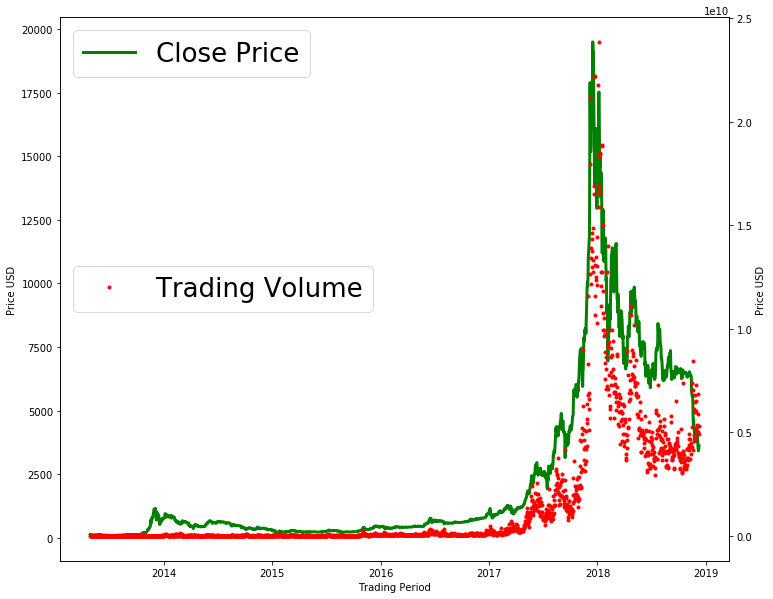

In [94]:
# Plot Basic Data
fig, ax1 = plt.subplots(figsize=(12, 10))
# Axis 1 - Adjusted Close
ax1.plot(btc_data["Date"], btc_data["BTC_Close"], 'green', label='Close Price',linewidth=3)
# Set X Axis label
ax1.set_xlabel('Trading Period')
# Set Y Axis label
ax1.set_ylabel('Price USD')

# Axis 2 - Volume
ax2 = ax1.twinx()
ax2.plot(btc_data["Date"], btc_data["BTC_Volume"], 'r.', color='red', label='Trading Volume')
# Set Y Axis label
ax2.set_ylabel('Volume')

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')

# Add title and legend
#ax1.set_title('Trading')
ax1.legend(loc=2, prop={'size': 26})
ax2.legend(loc=6, prop={'size': 26})


plt.show()

In [95]:
btc_data.tail()

,Date,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,BTC_Market_Cap
2047,2013-05-02,116.38,125.60,92.28,105.21,0.0,1168517495
2048,2013-05-01,139.00,139.89,107.72,116.99,0.0,1298954594
2049,2013-04-30,144.00,146.93,134.05,139.00,0.0,1542813125
2050,2013-04-29,134.44,147.49,134.00,144.54,0.0,1603768865
2051,2013-04-28,135.30,135.98,132.10,134.21,0.0,1488566728


As we can see, Coinmarcetcap starting to watch bitcoin since 2013 year, which is fine for my research

### Statistics of data

In [96]:
btc_data[['BTC_Volume', 'BTC_Close']].describe()

,BTC_Volume,BTC_Close
count,2.052000e+03,2052.000000
mean,1.469914e+09,2294.663168
std,3.048503e+09,3431.646128
min,0.000000e+00,68.430000
25%,1.874995e+07,322.920000
50%,5.881635e+07,602.000000
75%,1.294482e+09,2706.725000
max,2.384090e+10,19497.400000


## Data Preprocessing

### Holidays features

It's time to have some feature engineering. Somehow, holidays can affect price of cryptocurrency, I will find out wich countries trade most, and add those holidays to new feature. 

According to reddit bitcoin thread and bitcointalk forum, here is top countries of trading Bitcoin:

![](https://preview.redd.it/xm123r7ctth11.jpg?width=960&crop=smart&auto=webp&s=9f91c1761a6cb7063484a3b4c7b5e3f322fddf4a)

*resources:
* https://www.reddit.com/r/Bitcoin/comments/99mp73/which_country_trades_the_most_bitcoin/ 
* https://bitcointalk.org/index.php?topic=4943848.0

There is excellent library to catch holidays from top 3 countries of the list, but I will take top 5 to cover almost 70% of bitcoin trading

In [97]:
#using workalendar for holidays of USA, Russia and UK (almost 50% of all traffic)
from workalendar.europe import Russia
from workalendar.europe import UnitedKingdom
from workalendar.usa import UnitedStates

In [98]:
calRU = Russia()
calUK= UnitedKingdom()
calUS= UnitedStates()

Unfortunately, there is no lib to mark Chinese and Venezuelas holidays, so I will mark it by my own

The starts of public holidays for China are:

Same dates

* New Years Day Jan. 1
* Tomb Sweeping Day Apr. 5 (Qing Ming Jie)
* Labor Day May 1
* National Holiday Oct. 1

2013

* Spring Festival (which subject to the Lunation, also Chinese New year) Feb. 10 
* Tomb Sweeping Day Apr. 4
* Labor Day  Apr. 29
* Dragon Boat Festival Jun. 10
* Mid-Autumn Festival Sep. 19
2014

* Spring Festival Jan. 31
* Dragon Boat Festival May 31
* Mid-Autumn Festival Sep. 6

2015

* Spring Festival Feb. 18
* Dragon Boat Festival Jun. 20
* Mid-Autumn Festival Sep. 27
* 70 Year Anniversary of the Chinese people’s Resistance against Japan and the Global Victory over Fascism Sep. 3

2016

* Spring Festival Feb. 7
* Dragon Boat Festival Jun. 9
* Mid-Autumn Festival Sep. 15

2017

* Spring Festival Jun. 27
* Dragon Boat Festival May 28
* Mid-Autumn Festival Oct. 4

2018

* Spring Festival Feb. 15
* Dragon Boat Festival Jun. 18
* Mid-Autumn Festival Sep. 24

The starts of public holidays for Venezuela are:

Same dates

* New Year's Day Jan. 1
* Independence Day Jul. 5
* Labour Day May 1
* Christmas Dec 25
* Declaration of Independence Arp. 19
* Battle of Carabobo(St. John's Day) Jun. 24
* Simon Bolivar's Day Jul. 24
* Indigenous Resistance Day Oct. 12
* New Year's Eve Dec. 31

2013

* Carnival (Monday and Tuesday before Ash Wednesday) Feb. 11
* Maundy Thursday (The Thursday before Easter Sunday) Mar. 28
* Good Friday (Friday before Easter Sunday) Mar. 29

2014

* Carnival (Monday and Tuesday before Ash Wednesday) Mar. 3
* Maundy Thursday (The Thursday before Easter Sunday) Apr. 17
* Good Friday (Friday before Easter Sunday) Apr. 18

2015

* Carnival (Monday and Tuesday before Ash Wednesday) Feb. 16
* Maundy Thursday (The Thursday before Easter Sunday) Apr. 2
* Good Friday (Friday before Easter Sunday) Apr. 3

2016

* Carnival (Monday and Tuesday before Ash Wednesday) Feb. 8
* Maundy Thursday (The Thursday before Easter Sunday) Mar. 24
* Good Friday (Friday before Easter Sunday) Mar. 25

2017

* Carnival (Monday and Tuesday before Ash Wednesday) Feb. 27
* Maundy Thursday (The Thursday before Easter Sunday) Apr. 13
* Good Friday (Friday before Easter Sunday) Apr. 14

2018

* Carnival (Monday and Tuesday before Ash Wednesday) Feb. 12
* Maundy Thursday (The Thursday before Easter Sunday) Mar. 29
* Good Friday (Friday before Easter Sunday) Mar. 30


*resources:
* http://www.china-briefing.com/news/china-announces-official-2013-national-holiday-schedule/
* https://www.timeanddate.com/holidays/china/2016
* https://www.officeholidays.com/countries/venezuela/index.php

Checking if some holidays should be the same name or date. Also, skip same dates with same holidays (will mark holiday only True/False on dataframe)

In [99]:
calUS.holidays()

[(datetime.date(2018, 1, 1), 'New year'),
 (datetime.date(2018, 1, 15), 'Birthday of Martin Luther King, Jr.'),
 (datetime.date(2018, 2, 19), "Washington's Birthday"),
 (datetime.date(2018, 5, 28), 'Memorial Day'),
 (datetime.date(2018, 7, 4), 'Independence Day'),
 (datetime.date(2018, 9, 3), 'Labor Day'),
 (datetime.date(2018, 10, 8), 'Columbus Day'),
 (datetime.date(2018, 11, 11), 'Veterans Day'),
 (datetime.date(2018, 11, 12), 'Veterans Day (Observed)'),
 (datetime.date(2018, 11, 22), 'Thanksgiving Day'),
 (datetime.date(2018, 12, 25), 'Christmas Day')]

In [100]:
calUK.holidays()

[(datetime.date(2018, 1, 1), 'New year'),
 (datetime.date(2018, 3, 30), 'Good Friday'),
 (datetime.date(2018, 4, 1), 'Easter Sunday'),
 (datetime.date(2018, 4, 2), 'Easter Monday'),
 (datetime.date(2018, 5, 7), 'Early May Bank Holiday'),
 (datetime.date(2018, 5, 28), 'Spring Bank Holiday'),
 (datetime.date(2018, 8, 27), 'Late Summer Bank Holiday'),
 (datetime.date(2018, 12, 25), 'Christmas Day'),
 (datetime.date(2018, 12, 26), 'Boxing Day')]

In [101]:
calRU.holidays()

[(datetime.date(2018, 1, 1), 'New year'),
 (datetime.date(2018, 1, 2), 'Day After New Year'),
 (datetime.date(2018, 1, 7), 'Christmas'),
 (datetime.date(2018, 2, 23), 'Defendence of the Fatherland'),
 (datetime.date(2018, 3, 8), "International Women's Day"),
 (datetime.date(2018, 5, 1), 'Labour Day'),
 (datetime.date(2018, 5, 9), 'Victory Day'),
 (datetime.date(2018, 6, 12), 'National Day'),
 (datetime.date(2018, 11, 5), 'Day of Unity')]

In [102]:
# Chinese holidays
calCH = [(datetime.date(2018, 2, 5), 'Chinese New Year'),
         (datetime.date(2018, 4, 5), 'The Qingming Festival'),
         (datetime.date(2018, 6, 7), 'The Dragon Boat Festival'),
         (datetime.date(2018, 9, 13), 'The Mid-Autumn Festival'),
         (datetime.date(2018, 10, 1), 'National Day'),
         (datetime.date(2017, 1, 27), 'Chinese New Year'),
         (datetime.date(2017, 4, 5), 'The Qingming Festival'),
         (datetime.date(2017, 5, 28), 'The Dragon Boat Festival'),
         (datetime.date(2017, 10, 4), 'The Mid-Autumn Festival'),
         (datetime.date(2017, 10, 1), 'National Day'),
         (datetime.date(2016, 2, 7), 'Chinese New Year'),
         (datetime.date(2016, 4, 5), 'The Qingming Festival'),
         (datetime.date(2016, 6, 9), 'The Dragon Boat Festival'),
         (datetime.date(2016, 9, 15), 'The Mid-Autumn Festival'),
         (datetime.date(2016, 10, 1), 'National Day'),
         (datetime.date(2015, 2, 18), 'Chinese New Year'),
         (datetime.date(2015, 4, 5), 'The Qingming Festival'),
         (datetime.date(2015, 6, 20), 'The Dragon Boat Festival'),
         (datetime.date(2015, 9, 27), 'The Mid-Autumn Festival'),
         (datetime.date(2015, 9, 3), '70s Resistanse'),
         (datetime.date(2015, 10, 1), 'National Day'),
         (datetime.date(2014, 1, 31), 'Chinese New Year'),
         (datetime.date(2014, 4, 5), 'The Qingming Festival'),
         (datetime.date(2014, 5, 31), 'The Dragon Boat Festival'),
         (datetime.date(2014, 9, 6), 'The Mid-Autumn Festival'),
         (datetime.date(2014, 10, 1), 'National Day'),
         (datetime.date(2013, 2, 10), 'Chinese New Year'),
         (datetime.date(2013, 4, 5), 'The Qingming Festival'),
         (datetime.date(2013, 6, 10), 'The Dragon Boat Festival'),
         (datetime.date(2013, 9, 19), 'The Mid-Autumn Festival'),
         (datetime.date(2013, 10, 1), 'National Day')]

In [103]:
# Venezuelas holidays
calVE = [(datetime.date(2018, 7, 5), 'Venezuela Independence'),
         (datetime.date(2018, 4, 19), 'Declaration of Independence Ve'),
         (datetime.date(2018, 6, 24), 'St. John'),
         (datetime.date(2018, 7, 24), 'Simon Bolivar'),
         (datetime.date(2018, 1, 12), 'Indigenous Resistance'),
         (datetime.date(2018, 12, 31), 'New year"s eve'),
         (datetime.date(2018, 2, 12), 'Carnival'),
         (datetime.date(2018, 3, 29), 'Maundy Thursday'),
         (datetime.date(2018, 3, 30), 'Good Friday'),
         (datetime.date(2017, 7, 5), 'Venezuela Independence'),
         (datetime.date(2017, 4, 19), 'Declaration of Independence Ve'),
         (datetime.date(2017, 6, 24), 'St. John'),
         (datetime.date(2017, 7, 24), 'Simon Bolivar'),
         (datetime.date(2017, 1, 12), 'Indigenous Resistance'),
         (datetime.date(2017, 12, 31), 'New year"s eve'),
         (datetime.date(2017, 2, 27), 'Carnival'),
         (datetime.date(2017, 4, 13), 'Maundy Thursday'),
         (datetime.date(2017, 4, 14), 'Good Friday'),
         (datetime.date(2016, 7, 5), 'Venezuela Independence'),
         (datetime.date(2016, 4, 19), 'Declaration of Independence Ve'),
         (datetime.date(2016, 6, 24), 'St. John'),
         (datetime.date(2016, 7, 24), 'Simon Bolivar'),
         (datetime.date(2016, 1, 12), 'Indigenous Resistance'),
         (datetime.date(2016, 12, 31), 'New year"s eve'),
         (datetime.date(2016, 2, 8), 'Carnival'),
         (datetime.date(2016, 3, 24), 'Maundy Thursday'),
         (datetime.date(2016, 3, 25), 'Good Friday'),
         (datetime.date(2015, 7, 5), 'Venezuela Independence'),
         (datetime.date(2015, 4, 19), 'Declaration of Independence Ve'),
         (datetime.date(2015, 6, 24), 'St. John'),
         (datetime.date(2015, 7, 24), 'Simon Bolivar'),
         (datetime.date(2015, 1, 12), 'Indigenous Resistance'),
         (datetime.date(2015, 12, 31), 'New year"s eve'),
         (datetime.date(2015, 2, 16), 'Carnival'),
         (datetime.date(2015, 4, 2), 'Maundy Thursday'),
         (datetime.date(2015, 4, 3), 'Good Friday'),
         (datetime.date(2014, 7, 5), 'Venezuela Independence'),
         (datetime.date(2014, 4, 19), 'Declaration of Independence Ve'),
         (datetime.date(2014, 6, 24), 'St. John'),
         (datetime.date(2014, 7, 24), 'Simon Bolivar'),
         (datetime.date(2014, 1, 12), 'Indigenous Resistance'),
         (datetime.date(2014, 12, 31), 'New year"s eve'),
         (datetime.date(2014, 3, 3), 'Carnival'),
         (datetime.date(2014, 4, 17), 'Maundy Thursday'),
         (datetime.date(2014, 4, 18), 'Good Friday'),
         (datetime.date(2013, 7, 5), 'Venezuela Independence'),
         (datetime.date(2013, 4, 19), 'Declaration of Independence Ve'),
         (datetime.date(2013, 6, 24), 'St. John'),
         (datetime.date(2013, 7, 24), 'Simon Bolivar'),
         (datetime.date(2013, 1, 12), 'Indigenous Resistance'),
         (datetime.date(2013, 12, 31), 'New year"s eve'),
         (datetime.date(2013, 2, 11), 'Carnival'),
         (datetime.date(2013, 3, 28), 'Maundy Thursday'),
         (datetime.date(2013, 3, 29), 'Good Friday')]

In [104]:
#my dataset contain years from 2013 to 2018
years = []
for i in range(2013,2019):
    years.append(i)
clist = [calRU,calUK,calUS]

In [105]:
#working on full holidays list
holist=[]

for j in clist:
    for i in years:
        holist.append(j.holidays(i))

In [106]:
holist = [item for sublist in holist for item in sublist]

In [107]:
fullholist = calCH+calVE+holist

In [108]:
#removing dublicates
fullholist  = list(set(fullholist))

In [109]:
#making function "holi" to mark holidays in dataset
h=[]
for i in fullholist:
    h.append(i[0])

In [110]:
def holi(x):
    if x in h:
        return 1
    else: return 0

In [111]:
#check for simple date
btc_data['Date'][26]

Timestamp('2018-11-13 00:00:00')

In [113]:
btc_data['Month'] = btc_data['Date'].map(lambda x: x.month)

In [114]:
btc_data['Date']=pd.to_datetime(btc_data['Date']).apply(lambda x: x.date())

In [115]:
btc_data['Date'][26]

datetime.date(2018, 11, 13)

In [116]:
#shouldn't be holiday
holi(datetime.date(2018, 11, 13))

0

In [117]:
#should be holiday
holi(datetime.date(2015, 12, 25))

1

In [118]:
btc_data['Holiday'] =  btc_data['Date'].apply(lambda x: holi(x))

In [119]:
btc_data.tail(10)

,Date,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,BTC_Market_Cap,Month,Holiday
2042,2013-05-07,112.25,113.44,97.70,111.50,0.0,1240593600,5,0
2043,2013-05-06,115.98,124.66,106.64,112.30,0.0,1249023060,5,1
2044,2013-05-05,112.90,118.80,107.14,115.91,0.0,1288693176,5,0
2045,2013-05-04,98.10,115.00,92.50,112.50,0.0,1250316563,5,0
2046,2013-05-03,106.25,108.13,79.10,97.75,0.0,1085995169,5,0
2047,2013-05-02,116.38,125.60,92.28,105.21,0.0,1168517495,5,0
2048,2013-05-01,139.00,139.89,107.72,116.99,0.0,1298954594,5,1
2049,2013-04-30,144.00,146.93,134.05,139.00,0.0,1542813125,4,0
2050,2013-04-29,134.44,147.49,134.00,144.54,0.0,1603768865,4,0
2051,2013-04-28,135.30,135.98,132.10,134.21,0.0,1488566728,4,0


### Weekday and Weekend

In [120]:
btc_data['Weekday']=btc_data['Date'].apply(lambda x: x.isoweekday())
btc_data['Weekend']=btc_data['Weekday'].apply(lambda x: 1 if x in [6,7] else 0)

One-hot-encoding

In [121]:
temp=pd.get_dummies(btc_data['Weekday'],prefix='wd')
btc_data=pd.concat([btc_data,temp],axis=1)
btc_data=btc_data.drop('Weekday',axis=1)

In [122]:
btc_data.head()

,Date,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,BTC_Market_Cap,Month,Holiday,Weekend,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,wd_7
0,2018-12-09,3473.23,3685.31,3469.09,3614.23,4.947373e+09,62942160928,12,0,1,0,0,0,0,0,0,1
1,2018-12-08,3421.91,3506.04,3350.65,3476.11,5.305024e+09,60531278392,12,0,1,0,0,0,0,0,1,0
2,2018-12-07,3512.59,3512.59,3280.23,3419.94,6.835615e+09,59547645578,12,0,0,0,0,0,0,1,0,0
3,2018-12-06,3754.07,3874.97,3521.10,3521.10,5.878333e+09,61303965508,12,0,0,0,0,0,1,0,0,0
4,2018-12-05,3958.89,3969.54,3753.99,3753.99,5.302482e+09,65352496336,12,0,0,0,0,1,0,0,0,0


### Season features

In [123]:
def season(x):
    if x==1 or x==2 or x==12:
        return 1 #for Winter
    elif x==3 or x==4 or x==5:
        return 2 #for Spring
    elif x==6 or x==7 or x==8:
        return 3 #for Summer
    else: return 4 # for Autumn

In [124]:
btc_data['Month']=btc_data['Month'].apply(lambda x: season(x))

In [127]:
temp=pd.get_dummies(btc_data['Month'],prefix='season')
btc_data=pd.concat([btc_data,temp],axis=1)
btc_data=btc_data.drop('Month',axis=1)

In [129]:
#save to csv to avoid unnesessary changes 
btc_data.to_csv('data_csv.csv')

## More features 

Way of getting more features:
* download full blockchain history from cold wallet    
* download from www.blockchain.com  (or get it by json, for example, https://api.blockchain.info/charts/n-transactions?timespan=all&format=json)
* get from www.quandl.com (a lot of datasets free for personal or academic use, using blockchain.com but in a nice cvs ready format) - I chose this one, with my api key

**Number of confirmed transactions per day**

In [130]:
n_tran = pd.read_csv('BCHAIN-NTRAN.csv')
n_tran.columns=['Date','N_tran']

**Difficulty** is a measure of how difficult it is to find a hash below a given target. DIFF
A relative measure of how difficult it is to find a new block. The difficulty is adjusted periodically as a function of how much hashing power has been deployed by the network of miners.

In [131]:
diff = pd.read_csv('BCHAIN-DIFF.csv')
diff.columns=['Date','Diff']

In [132]:
diff.head()

,Date,Diff
0,2018-12-09,5.646404e+12
1,2018-12-08,5.646404e+12
2,2018-12-07,5.646404e+12
3,2018-12-06,5.646404e+12
4,2018-12-05,5.646404e+12


The **Average block size** in MB AVBLS

In [133]:
av_block = pd.read_csv('BCHAIN-AVBLS.csv')
av_block.columns=['Date','Block_Size']

**Miners Revenue**. Historical data showing (number of bitcoins mined per day + transaction fees) * market price. MIREV

In [134]:
miners = pd.read_csv('BCHAIN-MIREV.csv')
miners.columns=['Date','Mi_rev']

Data showing miners revenue divided by the number of transactions. - **Bitcoin Cost Per Transaction** CPTRA

In [135]:
bit_cost = pd.read_csv('BCHAIN-CPTRA.csv')
bit_cost.columns=['Date','Cost_tran']

In [136]:
bit_cost.head()

,Date,Cost_tran
0,2018-12-09,23.891661
1,2018-12-08,19.533192
2,2018-12-07,22.966951
3,2018-12-06,24.839415
4,2018-12-05,25.753689


The **Daily Median time take for transactions** to be accepted into a block. Bitcoin Median Transaction Confirmation Time
For now, there is no enought data - but for example, how can we get it straight from blockchain.info

In [137]:
res=[]

base_url = 'https://blockchain.info/charts/median-confirmation-time?timespan=all&format=json' 
response = requests.get(base_url)
results = response.json()
res.append(results)


In [138]:
#first time
res[0]['values'][0]

{'x': 1230940800, 'y': 0.0}

In [139]:
len(res[0]['values'])

1817

In [140]:
#nessesary fields examples
median_conform = res[0]['values'][1816]['y']
timeStamp = res[0]['values'][1816]['x']

In [145]:
f = csv.writer(open("conf_time.csv", "w"))
# header
f.writerow(["timeStamp","median_conf"])

for i in range(1817):
    f.writerow([res[0]['values'][i]['x'],
                res[0]['values'][i]['y']])


In [146]:
med = pd.read_csv('conf_time.csv')

In [147]:
med['date'] = med['timeStamp'].apply(datetime.datetime.fromtimestamp)

In [148]:
med.tail()

,timeStamp,median_conf,date
1809,1543536000,15.800000,2018-11-30 03:00:00
1810,1543708800,9.883333,2018-12-02 03:00:00
1811,1543881600,9.800000,2018-12-04 03:00:00
1812,1544054400,10.233333,2018-12-06 03:00:00
1813,1544227200,9.633333,2018-12-08 03:00:00


### Connecting all data to one dataframe

In [149]:
btc_data = pd.read_csv('data_csv.csv', index_col=0)

In [150]:
btc_data.head()

,Date,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,BTC_Market_Cap,Holiday,Weekend,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,wd_7,season_1,season_2,season_3,season_4
0,2018-12-09,3473.23,3685.31,3469.09,3614.23,4.947373e+09,62942160928,0,1,0,0,0,0,0,0,1,1,0,0,0
1,2018-12-08,3421.91,3506.04,3350.65,3476.11,5.305024e+09,60531278392,0,1,0,0,0,0,0,1,0,1,0,0,0
2,2018-12-07,3512.59,3512.59,3280.23,3419.94,6.835615e+09,59547645578,0,0,0,0,0,0,1,0,0,1,0,0,0
3,2018-12-06,3754.07,3874.97,3521.10,3521.10,5.878333e+09,61303965508,0,0,0,0,0,1,0,0,0,1,0,0,0
4,2018-12-05,3958.89,3969.54,3753.99,3753.99,5.302482e+09,65352496336,0,0,0,0,1,0,0,0,0,1,0,0,0


In [151]:
bit_n=btc_data.merge(n_tran, left_on='Date', right_on='Date')

In [152]:
bit_n.tail()

,Date,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,BTC_Market_Cap,Holiday,Weekend,wd_1,...,wd_3,wd_4,wd_5,wd_6,wd_7,season_1,season_2,season_3,season_4,N_tran
2047,2013-05-02,116.38,125.60,92.28,105.21,0.0,1168517495,0,0,0,...,0,1,0,0,0,0,1,0,0,57278.0
2048,2013-05-01,139.00,139.89,107.72,116.99,0.0,1298954594,1,0,0,...,1,0,0,0,0,0,1,0,0,50437.0
2049,2013-04-30,144.00,146.93,134.05,139.00,0.0,1542813125,0,0,0,...,0,0,0,0,0,0,1,0,0,48795.0
2050,2013-04-29,134.44,147.49,134.00,144.54,0.0,1603768865,0,0,1,...,0,0,0,0,0,0,1,0,0,50009.0
2051,2013-04-28,135.30,135.98,132.10,134.21,0.0,1488566728,0,1,0,...,0,0,0,0,1,0,1,0,0,40986.0


In [153]:
#check
n_tran.iloc[2051]['N_tran']

40986.0

In [154]:
bit_dif=bit_n.merge(diff, left_on='Date', right_on='Date')
bit_block=bit_dif.merge(av_block, left_on='Date', right_on='Date')
bit_miner=bit_block.merge(miners, left_on='Date', right_on='Date')
BTC_DATA=bit_miner.merge(bit_cost, left_on='Date', right_on='Date')

In [155]:
BTC_DATA.tail()

,Date,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,BTC_Market_Cap,Holiday,Weekend,wd_1,...,wd_7,season_1,season_2,season_3,season_4,N_tran,Diff,Block_Size,Mi_rev,Cost_tran
2047,2013-05-02,116.38,125.60,92.28,105.21,0.0,1168517495,0,0,0,...,0,0,1,0,0,57278.0,1.007629e+07,0.181150,383775.10965,6.700218
2048,2013-05-01,139.00,139.89,107.72,116.99,0.0,1298954594,1,0,0,...,0,0,1,0,0,50437.0,1.007629e+07,0.159960,442507.28800,8.773466
2049,2013-04-30,144.00,146.93,134.05,139.00,0.0,1542813125,0,0,0,...,0,0,1,0,0,48795.0,1.007629e+07,0.176944,525692.91100,10.773500
2050,2013-04-29,134.44,147.49,134.00,144.54,0.0,1603768865,0,0,1,...,0,0,1,0,0,50009.0,8.974296e+06,0.133635,645240.09120,12.902479
2051,2013-04-28,135.30,135.98,132.10,134.21,0.0,1488566728,0,1,0,...,1,0,1,0,0,40986.0,8.974296e+06,0.120677,572109.88793,13.958666


In [156]:
BTC_DATA.dtypes

Date               object
BTC_Open          float64
BTC_High          float64
BTC_Low           float64
BTC_Close         float64
BTC_Volume        float64
BTC_Market_Cap      int64
Holiday             int64
Weekend             int64
wd_1                int64
wd_2                int64
wd_3                int64
wd_4                int64
wd_5                int64
wd_6                int64
wd_7                int64
season_1            int64
season_2            int64
season_3            int64
season_4            int64
N_tran            float64
Diff              float64
Block_Size        float64
Mi_rev            float64
Cost_tran         float64
dtype: object

In [159]:
BTC_DATA.isnull().values.any()

False

## DATA exploration

In [160]:
# correlation between columns, the closer to "1", the more correlated 
BTC_DATA.corr()      

,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,BTC_Market_Cap,Holiday,Weekend,wd_1,wd_2,...,wd_7,season_1,season_2,season_3,season_4,N_tran,Diff,Block_Size,Mi_rev,Cost_tran
BTC_Open,1.000000,0.998919,0.998076,0.997648,0.941456,0.997524,0.006360,0.000795,-0.000365,0.000128,...,0.000821,0.115944,-0.034277,-0.067885,-0.008136,0.511712,0.681335,0.562675,0.974464,0.867555
BTC_High,0.998919,1.000000,0.997897,0.999132,0.945146,0.998725,0.007182,-0.000355,-0.000490,0.000283,...,-0.000990,0.121711,-0.036015,-0.069995,-0.009780,0.512760,0.670957,0.561474,0.975771,0.866322
BTC_Low,0.998076,0.997897,1.000000,0.998716,0.930660,0.998878,0.006903,0.002316,0.000449,-0.000173,...,0.000860,0.106111,-0.032870,-0.064613,-0.003500,0.513295,0.693732,0.565566,0.969162,0.865290
BTC_Close,0.997648,0.999132,0.998716,1.000000,0.939340,0.999776,0.007085,0.001191,-0.000111,-0.000092,...,-0.000082,0.115537,-0.035189,-0.067571,-0.007184,0.514003,0.678911,0.563013,0.972442,0.864581
BTC_Volume,0.941456,0.945146,0.930660,0.939340,1.000000,0.938677,0.007361,-0.031058,-0.008310,0.007211,...,-0.020688,0.173702,-0.027189,-0.090688,-0.046618,0.459880,0.597273,0.500708,0.940416,0.806779
BTC_Market_Cap,0.997524,0.998725,0.998878,0.999776,0.938677,1.000000,0.006661,0.001262,-0.000154,-0.000133,...,-0.000011,0.109138,-0.034476,-0.065437,-0.003976,0.517207,0.691122,0.568245,0.969411,0.859400
Holiday,0.006360,0.007182,0.006903,0.007085,0.007361,0.006661,1.000000,-0.064334,0.174215,-0.043636,...,-0.025525,0.053741,0.039475,-0.052715,-0.036009,-0.028068,-0.012488,-0.024135,0.010199,0.035685
Weekend,0.000795,-0.000355,0.002316,0.001191,-0.031058,0.001262,-0.064334,1.000000,-0.258346,-0.258346,...,0.646047,0.001064,-0.000794,0.000228,-0.000464,-0.037293,0.001975,-0.028502,-0.000515,0.029486
wd_1,-0.000365,-0.000490,0.000449,-0.000111,-0.008310,-0.000154,0.174215,-0.258346,1.000000,-0.166572,...,-0.166903,0.001061,-0.001750,0.000569,0.000120,-0.084868,-0.001445,-0.066521,0.000293,0.046060
wd_2,0.000128,0.000283,-0.000173,-0.000092,0.007211,-0.000133,-0.043636,-0.258346,-0.166572,1.000000,...,-0.166903,0.001061,0.001508,-0.002572,0.000120,0.010052,-0.000884,0.019210,-0.001351,-0.015307


In [163]:
BTC_DATA.to_csv('BTC_DATA2.csv')

In [9]:
BTC_DATA = pd.read_csv('BTC_DATA2.csv', index_col=0).set_index('Date').dropna(axis=1)
BTC_DATA.shape

(2052, 24)

### FINANCIAL Features

In statistics, a **moving average** (rolling average or running average) is a calculation to analyze data points by creating a series of averages of different subsets of the full data set

In [10]:
# Moving average indicators
BTC_DATA['MA7'] = BTC_DATA.BTC_Close.rolling(7).mean() # week
#BTC_DATA['MA30'] = BTC_DATA.BTC_Close.rolling(30).mean() #month

**Stochastic Osciallator**. The indicator picks one observation point in current base and refers to all points in the defined range from where the highest and lowest point are considered for comparison. It helps to decide the current momentum when compared to high & low of historic set in form of support and resistance levels. For this the consideration point is price of the security in a term defined but it never follows the price pattern as it tracks the momentum or oscillation in the price movement.

In [11]:
# Stochastic Osciallator
BTC_DATA['SO'] = (BTC_DATA['BTC_Close'] - BTC_DATA['BTC_Low']) / (BTC_DATA['BTC_High'] - BTC_DATA['BTC_Low'])

Pricing anomaly is term as “time series momentum,” which is remarkably consistent across very different asset classes and markets.

In [12]:
# 14, 7 and 2 Day Momentum
BTC_DATA['Momentum_14'] = BTC_DATA['BTC_Close'].diff(14)
BTC_DATA['Momentum_7'] = BTC_DATA['BTC_Close'].diff(7)
BTC_DATA['Momentum_2'] = BTC_DATA['BTC_Close'].diff(2)

In [13]:
BTC_DATA.dropna(inplace=True)

In [14]:
BTC_DATA.shape

(2037, 29)

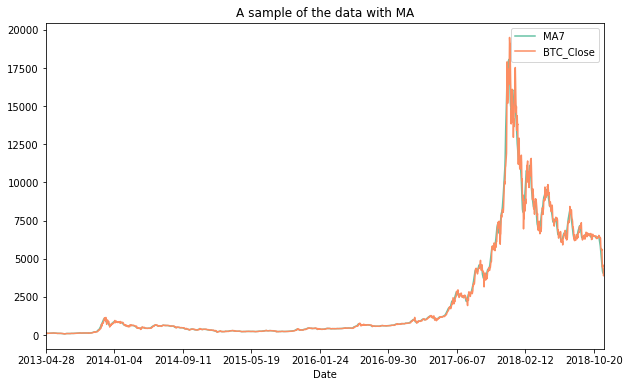

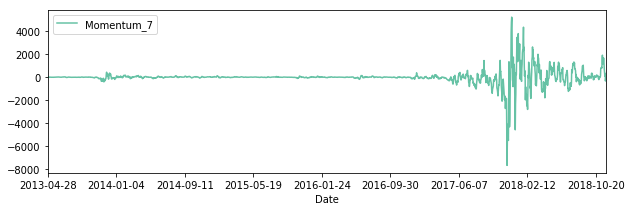

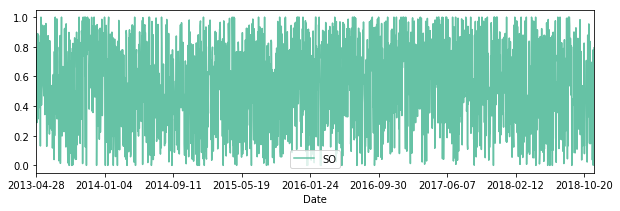

In [16]:
# sort by date
BTC_DATA=BTC_DATA.sort_index()
BTC_DATA.plot(x=BTC_DATA.index, y=['MA7', 'BTC_Close'], figsize=(10,6), title="A sample of the data with MA");
BTC_DATA.plot(x=BTC_DATA.index, y=['Momentum_7'], figsize=(10,3));
BTC_DATA.plot(x=BTC_DATA.index, y=['SO'], figsize=(10,3));


*resources:
 - https://www.investopedia.com/terms/m/movingaverage.asp
 - https://www.kaggle.com/andreicosma/introduction-in-time-series-moving-average
 - https://towardsdatascience.com/trend-seasonality-moving-average-auto-regressive-model-my-journey-to-time-series-data-with-edc4c0c8284b

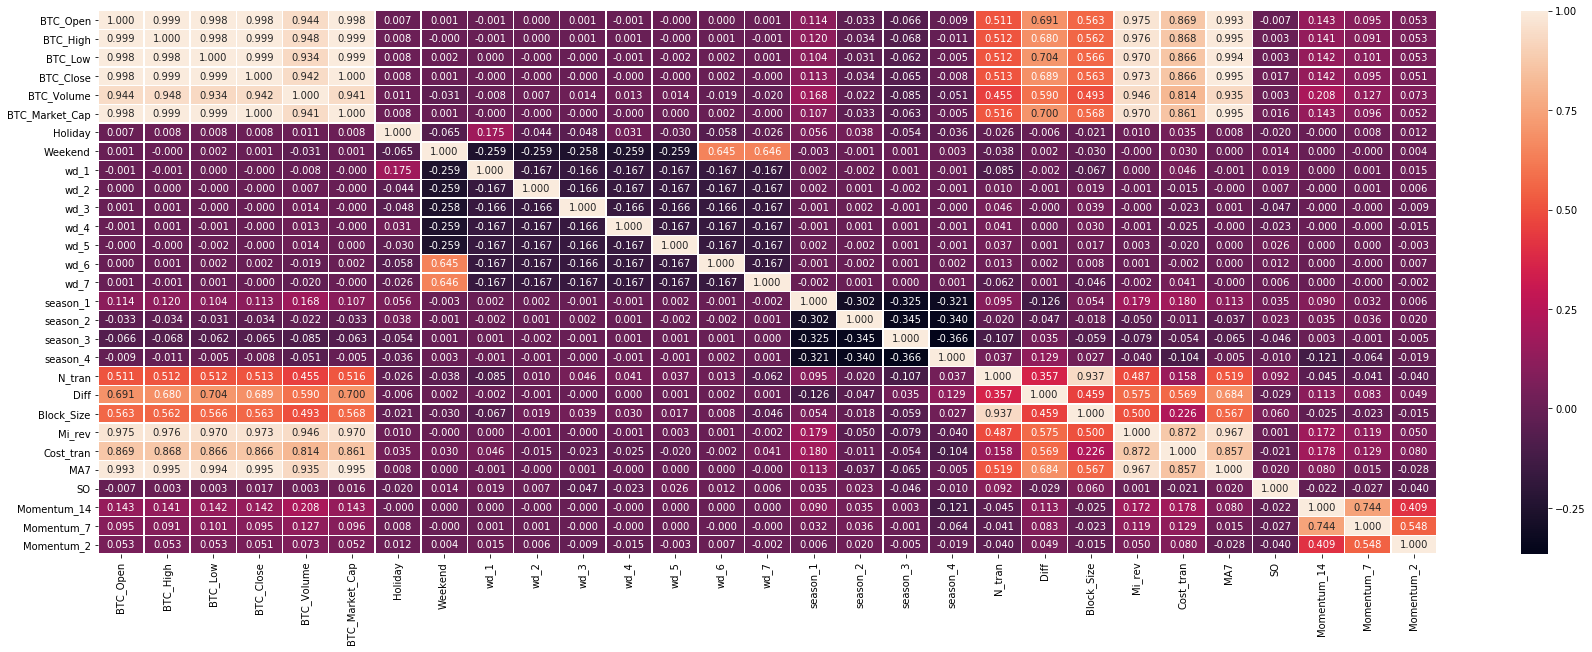

In [42]:
# heatmap
f,ax = plt.subplots(figsize=(30, 10))                                        
sns.heatmap(BTC_DATA.corr(), annot=True, linewidths=.5, fmt= '.3f',ax=ax)   
plt.show()

In [288]:
BTC_DATA.to_csv('BTC_DATA_fin.csv')

# RESEARCH TRENDS

Most time series data can be described by three components. And those are trend, seasonality and bias.

- Trend → a general systematic linear or (most often) nonlinear component that changes over time and does not repeat
- Seasonality → a general systematic linear or (most often) nonlinear component that changes over time and does repeat. In other words, captures patterns that repeat every season
- Noise → a non-systematic component that is nor Trend/Seasonality within the data. It is what left

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

c:\users\pff\appdata\local\programs\python\python35\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [19]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

from numpy import newaxis
%matplotlib inline

In [20]:
init_notebook_mode(connected=True)

In [34]:
df = BTC_DATA.copy()
df['Mean'] = (df.BTC_High + df.BTC_Low )/2.0

In [30]:
decomposition = seasonal_decompose(df.Mean.values, freq=365) 
trace1 = go.Scatter(
    x = df.index,y = decomposition.trend,
    name = 'Trend',mode='line'
)
trace2 = go.Scatter(
    x = df.index,y = decomposition.seasonal,
    name = 'Seasonal',mode='line'
)
trace3 = go.Scatter(
    x = df.index,y = decomposition.resid,
    name = 'Residual',mode='line'
)
trace4 = go.Scatter(
    x = df.index,y = df.Mean,
    name = 'Mean Stock Value',mode='line'
)

In [31]:
#iplot is inline
data = [trace1,trace2,trace3,trace4]
iplot(data)

In [35]:
df.index = pd.to_datetime(df.index)
data = df['BTC_Close']

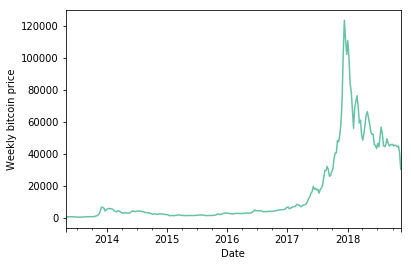

In [36]:
weekly = data.resample('W').sum()
weekly.plot()
plt.ylabel('Weekly bitcoin price')

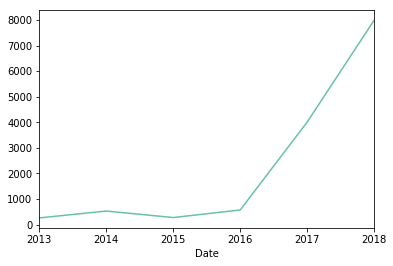

In [37]:
by_year = data.groupby(data.index.year).mean()
by_year.plot()

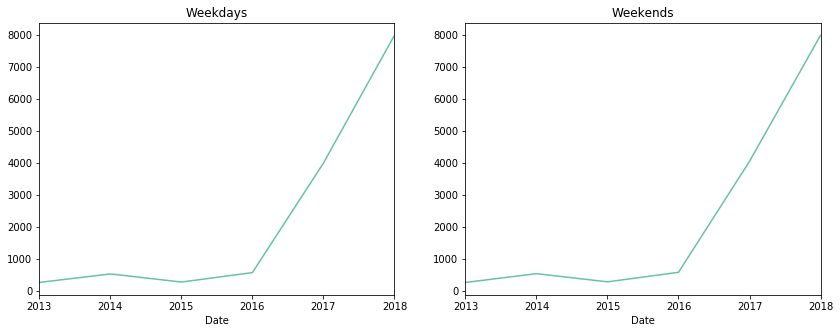

In [38]:
weekend = np.where(data.index.weekday < 5, 'Weekday', 'Weekend')
by_time = data.groupby([weekend, data.index.year]).mean()
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays')
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends')

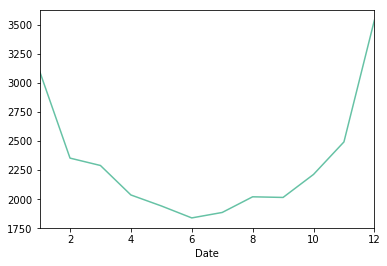

In [39]:
by_month = data.groupby(data.index.month).mean()
by_month.plot()

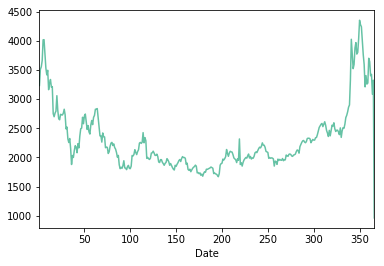

In [40]:
by_day = data.groupby(data.index.dayofyear).mean()
by_day.plot()